<a href="https://colab.research.google.com/github/peace-and-harmony/image-matting/blob/main/notebooks/modnet_tensorrt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorRT Based Inference

In this demo, TensorRT is used for inference the image segmentation MODNet which is pretrained in the domain of clothing matting.

- TensorRT 8.0.0.3 is installed.

- TensorRT engine is generated via checkpoint.onnx which is converted from pretrained MODNet model. For more information, please check the current repository/notebooks.

- Thanks to jkjung-avt for the TensorRT Version of MODNet.

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Thu Sep 23 04:34:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |            

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# TensorRT installation
- deb install

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin

!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600

!wget http://developer.download.nvidia.com/compute/cuda/11.0.2/local_installers/cuda-repo-ubuntu1804-11-0-local_11.0.2-450.51.05-1_amd64.deb

!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!sudo apt-get update
!wget http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!sudo apt-get update

!apt-get install -y --no-install-recommends libnvinfer8 libnvinfer-dev  python3-libnvinfer-dev
!pip install pycuda

In [4]:
%cd /content
!cp /content/drive/MyDrive/package/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz /content
!tar -xzf /content/TensorRT-8.0.0.3.Linux.x86_64-gnu.cuda-11.3.cudnn8.2.tar.gz

/content


In [5]:
%cd /content/TensorRT-8.0.0.3
print('Installing necessary Python wheels...')
!pip3 install /content/TensorRT-8.0.0.3/python/tensorrt-8.0.0.3-cp37-none-linux_x86_64.whl

/content/TensorRT-8.0.0.3
Installing necessary Python wheels...
Processing ./python/tensorrt-8.0.0.3-cp37-none-linux_x86_64.whl


In [ ]:
!sudo dpkg -i /content/drive/MyDrive/package/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423_1-1_amd64.deb
!sudo apt-key add /var/nv-tensorrt-repo-ubuntu1804-cuda11.3-trt8.0.0.3-ea-20210423/7fa2af80.pub
!sudo apt-get update
!sudo apt-get install tensorrt

Check the installation and test using python

In [7]:
!dpkg -l | grep TensorRT

ii  libnvinfer-dev                                              8.0.3-1+cuda11.3                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                                       8.0.3-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer-plugin8                                          8.0.3-1+cuda11.3                    amd64        TensorRT plugin libraries
ii  libnvinfer8                                                 8.0.3-1+cuda11.3                    amd64        TensorRT runtime libraries
ii  libnvonnxparsers-dev                                        8.0.3-1+cuda11.3                    amd64        TensorRT ONNX libraries
ii  libnvonnxparsers8                                           8.0.3-1+cuda11.3                    amd64        TensorRT ONNX libraries
ii  libnvparsers-dev                                            8.0.3-1+cuda11.3                    amd64        TensorRT parsers libraries
ii  libnvpar

In [8]:
!python -c 'import tensorrt as trt'

## TensorRT inference

In [9]:
%cd /content/
!git clone https://github.com/jkjung-avt/tensorrt_demos.git

/content
Cloning into 'tensorrt_demos'...
remote: Enumerating objects: 1645, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1645 (delta 27), reused 35 (delta 18), pack-reused 1597
Receiving objects: 100% (1645/1645), 212.90 MiB | 40.96 MiB/s, done.
Resolving deltas: 100% (1032/1032), done.
Checking out files: 100% (106/106), done.


### ONNX simplifier (adding input dimensions)
- ONNX simplifier is used for simplifying the model and adding input dimensions for further TensorRT engine generation.

In [ ]:
!pip3 install -U pip && pip3 install onnx-simplifier

In [11]:
%cp /content/drive/MyDrive/modnet-gpu.onnx /content/tensorrt_demos/modnet/

In [14]:
!python3 -m onnxsim /content/tensorrt_demos/modnet/modnet-gpu.onnx /content/tensorrt_demos/modnet/modnet-simplified.onnx --input-shape 1,3,512,512

Simplifying...
Note: The input shape of the simplified model will be overwritten by the value of '--input-shape' argument. Pass '--dynamic-input-shape' if it is not what you want. Run 'python3 -m onnxsim -h' for details.
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


In [15]:
%ls /content/tensorrt_demos/modnet/

image.jpg        modnet-simplified.onnx  README.md
modnet-gpu.onnx  onnx-tensorrt/          test_onnx.py
modnet.onnx      onnx_to_tensorrt.py     torch2onnx/


In [16]:
%cd /content/tensorrt_demos/modnet/
!python3 onnx_to_tensorrt.py modnet-simplified.onnx modnet.engine

/content/tensorrt_demos/modnet
Building an engine.  This would take a while...
(Use "-v" or "--verbose" to enable verbose logging.)
[TensorRT] WARNING: onnx2trt_utils.cpp:364: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[TensorRT] WARNING: onnx2trt_utils.cpp:390: One or more weights outside the range of INT32 was clamped
[TensorRT] WARNING: ShapedWeights.cpp:173: Weights 1168 has been transposed with permutation of (1, 0)! If you plan on overwriting the weights with the Refitter API, the new weights must be pre-transposed.
[TensorRT] WARNING: ShapedWeights.cpp:173: Weights 1169 has been transposed with permutation of (1, 0)! If you plan on overwriting the weights with the Refitter API, the new weights must be pre-transposed.
onnx_to_tensorrt.py:92: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)
[TensorRT] WARNING: TensorRT was linked a

In [19]:
%ls /content/tensorrt_demos/modnet/

image.jpg        modnet.onnx             onnx_to_tensorrt.py  torch2onnx/
modnet.engine    modnet-simplified.onnx  README.md
modnet-gpu.onnx  onnx-tensorrt/          test_onnx.py


### Upload inference image

In [21]:
import shutil
from google.colab import files
import os

# clean and rebuild the image folders
input_folder = '/content/tensorrt_demos/modnet/test_in'
if os.path.exists(input_folder):
  shutil.rmtree(input_folder)
os.makedirs(input_folder)

# upload images (PNG or JPG)
image_names = list(files.upload().keys())
for image_name in image_names:
  shutil.move(image_name, os.path.join(input_folder, image_name))

Saving mariabeatrice-alonzi-VyI0GBHSsJ8-unsplash.jpg to mariabeatrice-alonzi-VyI0GBHSsJ8-unsplash.jpg


['/content/tensorrt_demos/modnet/test_in/mariabeatrice-alonzi-VyI0GBHSsJ8-unsplash.jpg']


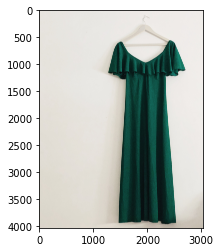

In [2]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
from PIL import Image

img_path = glob.glob('/content/tensorrt_demos/modnet/test_in/*.jpg')
print(img_path)
img = cv2.imread(img_path[0]) # reads image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

/content/tensorrt_demos


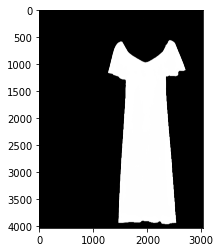

In [3]:
%cd /content/tensorrt_demos
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import pycuda.autoinit
from utils.modnet import TrtMODNet
import tensorrt as trt
import matplotlib.pyplot as plt


img = cv2.imread(img_path[0])

modnet = TrtMODNet()
TRT_LOGGER = trt.Logger(trt.Logger.INFO)
matte = modnet.infer(img)
plt.imshow(cv2.cvtColor(matte, cv2.COLOR_BGR2RGB))